In [1]:
from theta.rtbm import RTBM
import numpy as np
import matplotlib.pyplot as plt
from theta.minimizer import CMA, SGD
from theta import costfunctions
%matplotlib inline

In [10]:
ndim = 4
nhid = 3
rtbm = RTBM(ndim, nhid, 
            minimization_bound=55, 
            positive_T=True, 
            positive_Q=True,
            gaussian_init=True
           )

def espacio(sample, n=1e5):
    n = int(n)
    u = np.max(sample)
    l = np.min(sample)
    epsilon = np.abs(u)/4.0
    u += epsilon
    l -= epsilon
    r = np.random.rand(ndim, n)
    return l + r*(u-l), pow(u-l, ndim)/n

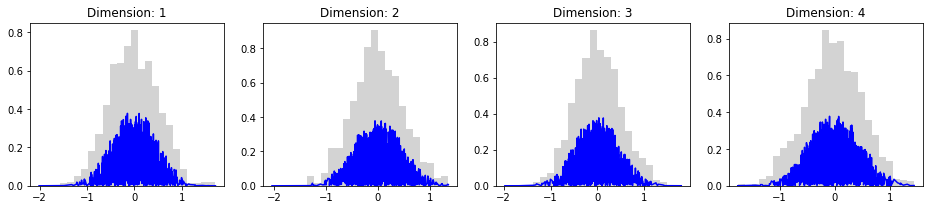

In [11]:
plt.rcParams['figure.figsize'] = [16, 3]

def dome(nevt=1e3, do_rho=True):
    # Sample after gaussian initialization
    nevt = int(nevt)
    xrand, _ = rtbm.make_sample(nevt)
    jac = rtbm(xrand.T)
    
    for d in range(ndim):
        plt.subplot(1,ndim,d+1)
        plt.title(f"Dimension: {d+1}")
        if do_rho:
            x = sorted(xrand[:,d])
            y = [i for _, i in sorted(zip(xrand[:,d], jac[0]))]
            plt.plot(x, y, color="blue", label=f"p(x_{d+1})")
        plt.hist(xrand[:, d], bins=25, density=True, color="lightgray", label="Sample")
    plt.show()
    return xrand
xrand = dome()

In [12]:
r, jac = espacio(xrand, n=1e5)
aa = rtbm(r)
print(np.sum(aa)*jac)

1.062542667860211


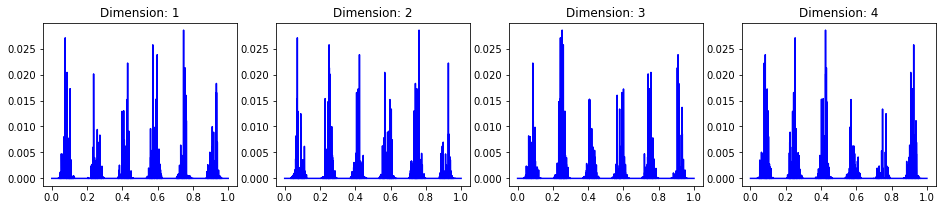

Current mse: 0.0063037919159866975
Current KL: 3.4260484856498707


In [13]:
# Now train the RTBM to a _different_ functional form
from scipy.special import expit
n = int(1e4)
ff = lambda x: np.prod(np.sin(x*np.pi*6)**12, axis=1)
xvals = np.random.rand(n, ndim)
yvals_raw = ff(xvals)
yvals = yvals_raw/np.sum(yvals_raw)
for d in range(ndim):
    plt.subplot(1,ndim,d+1)
    plt.title(f"Dimension: {d+1}")
    x = sorted(xvals[:,d])
    y = [i for _, i in sorted(zip(xvals[:,d], yvals))]
    plt.plot(x, y, color="blue", label=f"p(x_{d+1})")
    #plt.hist(xrand[:, d], bins=25, density=True, color="lightgray", label="Sample")
plt.show()

current_val = rtbm(xvals.T)[0]
print(f"Current mse: {costfunctions.mse.cost(current_val, yvals)}")
print(f"Current KL: {costfunctions.kullbackLeibler.cost(current_val, yvals)}")

In [15]:
from cma import CMAEvolutionStrategy

x0 = rtbm.get_parameters()
bounds = rtbm.get_bounds()

def optimize(n=1):
    sigma = np.min(bounds[1])/(4.0*n)
    es = CMAEvolutionStrategy(x0, sigma, {"bounds":bounds, "maxiter":250})
    # Create a function to be optimized:
    def fun_crate(xin, ytrue, mode = "kl"):
        def objective_fun(params=None):
            if params is not None and not rtbm.set_parameters(params):
                return np.NaN
            prob = rtbm(xin.T)
            if mode == "kl":
                return -np.sum(ytrue*np.log(prob))
            elif mode == "mse":
                return np.sum((prob-ytrue)**2)

        return objective_fun

    target = fun_crate(xvals, yvals, mode="kl")
    es.optimize(target)
    return es.result
    
n = 1
res = optimize(n)
while not rtbm.set_parameters(res.xbest):
    print("Rerunning the optimization, changing sigma")
    n+=1
    optimize(n)    

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 35 (seed=1063984, Wed Feb 10 16:38:38 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.180136670240224e+01 1.0e+00 1.67e+00  2e+00  2e+00 0:00.2
    2     28 4.947074932678914e+00 1.1e+00 1.63e+00  2e+00  2e+00 0:00.3


/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [0, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13]/[] are nan/None and will be set to the median value 20.881606659089236 (class=CMAEvolutionStrategy method=ask )
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]/[] are nan/None and will be set to the median value 40.10632464252449 (class=CMAEvolutionStrategy method=ask iteration=1)
  warnings.warn(msg + ' (' +


    3     42 1.282095305411642e+01 1.1e+00 1.62e+00  2e+00  2e+00 0:00.5


/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [0, 3, 4, 5, 7, 8, 10, 11, 12, 13]/[] are nan/None and will be set to the median value 18.64040293008526 (class=CMAEvolutionStrategy method=ask iteration=2)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13]/[] are nan/None and will be set to the median value 50.29801408210578 (class=CMAEvolutionStrategy method=ask iteration=3)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [0, 1, 2, 4, 5, 6, 7, 8, 12]/[] are nan/None and will be set to the median value 14.501781046137355 (class=CMAEvolutionStrategy method=ask iteration=4)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:34

   11    154 2.648144233967321e+00 1.2e+00 1.58e+00  2e+00  2e+00 0:03.6


/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [2, 3, 11]/[] are nan/None and will be set to the median value 7.212582627351038 (class=CMAEvolutionStrategy method=ask iteration=10)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [2, 3, 6, 7, 12, 13]/[] are nan/None and will be set to the median value 8.18754903057926 (class=CMAEvolutionStrategy method=ask iteration=11)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [1, 2, 3, 4, 6, 7, 11, 12]/[] are nan/None and will be set to the median value 12.787688283425659 (class=CMAEvolutionStrategy method=ask iteration=12)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [

   20    280 4.149057289268670e+00 1.3e+00 1.42e+00  1e+00  1e+00 0:07.7


/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [0, 6, 7, 10, 11, 13]/[] are nan/None and will be set to the median value 6.758456852675894 (class=CMAEvolutionStrategy method=ask iteration=19)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [0, 2, 3, 6, 10]/[] are nan/None and will be set to the median value 4.74579857202351 (class=CMAEvolutionStrategy method=ask iteration=20)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [2, 4, 12]/[] are nan/None and will be set to the median value 4.819899927519543 (class=CMAEvolutionStrategy method=ask iteration=21)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [5, 9, 12, 

   30    420 2.494507992017860e+00 1.4e+00 1.14e+00  1e+00  1e+00 0:13.3


/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [0, 8, 9, 10, 11]/[] are nan/None and will be set to the median value 6.482025780872495 (class=CMAEvolutionStrategy method=ask iteration=30)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [4]/[] are nan/None and will be set to the median value 4.87723311919841 (class=CMAEvolutionStrategy method=ask iteration=31)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [3, 7, 8]/[] are nan/None and will be set to the median value 4.3847322944459055 (class=CMAEvolutionStrategy method=ask iteration=32)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [5, 7]/[] are nan/None and w

   40    560 2.173774086237560e+00 1.4e+00 1.10e+00  1e+00  1e+00 0:19.9


/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [13]/[] are nan/None and will be set to the median value 5.251568604638566 (class=CMAEvolutionStrategy method=ask iteration=40)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [1, 5, 7, 10, 13]/[] are nan/None and will be set to the median value 4.47403539109741 (class=CMAEvolutionStrategy method=ask iteration=41)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [0, 13]/[] are nan/None and will be set to the median value 4.225818380176113 (class=CMAEvolutionStrategy method=ask iteration=42)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [5]/[] are nan/None and will b

   50    700 1.684872403849485e+00 1.5e+00 9.55e-01  9e-01  1e+00 0:26.9


/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [10]/[] are nan/None and will be set to the median value 2.6967187686686054 (class=CMAEvolutionStrategy method=ask iteration=51)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [0]/[] are nan/None and will be set to the median value 3.395603341026211 (class=CMAEvolutionStrategy method=ask iteration=52)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [1]/[] are nan/None and will be set to the median value 2.579380109215161 (class=CMAEvolutionStrategy method=ask iteration=57)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [10]/[] are nan/None and will be set to the me

   61    854 1.073389712395116e+00 1.5e+00 7.40e-01  6e-01  8e-01 0:35.4


/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [6, 8]/[] are nan/None and will be set to the median value 2.229748421606199 (class=CMAEvolutionStrategy method=ask iteration=61)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [11]/[] are nan/None and will be set to the median value 1.8559870873481403 (class=CMAEvolutionStrategy method=ask iteration=62)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [5, 13]/[] are nan/None and will be set to the median value 2.413177779366775 (class=CMAEvolutionStrategy method=ask iteration=63)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [13]/[] are nan/None and will be set to

   74   1036 1.380828747928937e+00 1.7e+00 6.69e-01  6e-01  7e-01 0:44.8


/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [0]/[] are nan/None and will be set to the median value 1.5076542554533787 (class=CMAEvolutionStrategy method=ask iteration=76)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [12]/[] are nan/None and will be set to the median value 1.5746158868044775 (class=CMAEvolutionStrategy method=ask iteration=78)
  warnings.warn(msg + ' (' +


   87   1218 1.015204519174410e+00 1.7e+00 4.44e-01  4e-01  5e-01 0:54.9
  100   1400 9.593455719257445e-01 1.8e+00 3.66e-01  3e-01  4e-01 1:05.4


/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [1]/[] are nan/None and will be set to the median value 1.0675314365496245 (class=CMAEvolutionStrategy method=ask iteration=107)
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning: function values with index [4]/[] are nan/None and will be set to the median value 0.9755763680758088 (class=CMAEvolutionStrategy method=ask iteration=110)
  warnings.warn(msg + ' (' +


  117   1638 8.260242756433972e-01 1.9e+00 2.94e-01  2e-01  3e-01 1:17.9
  136   1904 7.732007323174752e-01 2.5e+00 2.94e-01  2e-01  3e-01 1:31.6
  154   2156 7.066934699243037e-01 2.9e+00 3.15e-01  2e-01  4e-01 1:45.7
  174   2436 6.952473082232209e-01 3.5e+00 3.63e-01  2e-01  4e-01 2:01.2
  197   2758 6.353127966796726e-01 3.8e+00 2.15e-01  1e-01  3e-01 2:17.9
  200   2800 6.253942132970295e-01 3.9e+00 2.11e-01  1e-01  3e-01 2:20.0
  225   3150 6.226068235997140e-01 4.2e+00 1.74e-01  1e-01  2e-01 2:38.6
  250   3500 6.144639120086541e-01 4.6e+00 1.20e-01  7e-02  1e-01 2:56.2


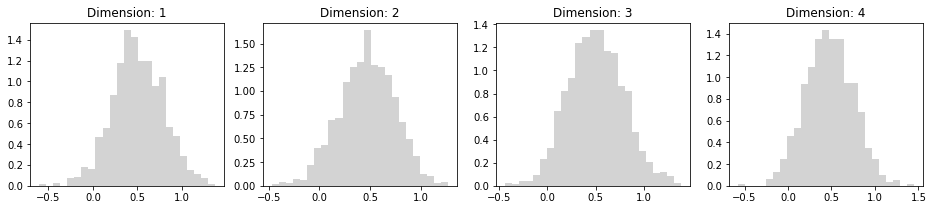

Current mse: 1.7553310314421242
Current KL: -0.17465898733733803
Integral:
0.992699836834607


In [16]:
new_sample = dome(do_rho=False)
new_pred = rtbm(new_sample.T)[0]
new_y_raw = ff(new_sample)
new_y = new_y_raw/np.sum(new_y_raw)
print(f"Current mse: {costfunctions.mse.cost(new_pred, new_y)}")
print(f"Current KL: {costfunctions.kullbackLeibler.cost(new_pred, new_y)}")
print("Integral:")
r, jac = espacio(new_sample, n=1e5)
aa = rtbm(r)
print(np.sum(aa)*jac)